# Generating heatmap for the chemotaxonomy

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants
from ete3 import NCBITaxa

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import chisquare

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [3]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

### Load chemicals

In [4]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [5]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [6]:
len(plant_chemical_df.chemical_curie.unique())

87019

### Collapsing plant species to plant families

In [7]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique())
)

order genus: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16884/16884 [00:00<00:00, 25461.41it/s]


In [8]:
len(family_to_species)

513

## Generating family chemical space vectors

In [9]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

In [10]:
medicinal_plants = set(plant_disease_df.plant_curie.unique())

In [12]:
def create_family_compound_vectors(family_mapper: dict, df: pd.DataFrame):
    """Plot chemical distribution."""
    
    rows = []
    
    for taxon_name, species in tqdm(family_mapper.items()):
        tmp_df = df[df['plant_curie'].isin(species)]

        total_chemicals = tmp_df.chemical_curie.unique()

        unique_chemicals = set()

        med_plants_in_fam = medicinal_plants.intersection(set(species))

        for chem in total_chemicals:
            chem_plants = set(df[df['chemical_curie'] == chem]['plant_curie'].unique())

            non_fam_plants = chem_plants - set(species)

            if len(non_fam_plants) < 1:
                unique_chemicals.add(chem)
        
        rows.append({
            'family': taxon_name,
            '# chemicals': len(total_chemicals),
            '# family specific chemicals': len(unique_chemicals),
            '# med plants': len(med_plants_in_fam),
            '# plants in fam': len(species),
            'plants in fam': species
        })
        
    return pd.DataFrame(rows)

In [13]:
family_df = create_family_compound_vectors(family_to_species, plant_chemical_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [1:36:21<00:00, 11.27s/it]


In [14]:
family_df.head()

,family,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam
0,ncbitaxon:3536,243,59,5,15,"[ncbitaxon:122400, ncbitaxon:427792, ncbitaxon..."
1,ncbitaxon:4037,4652,1487,105,436,"[ncbitaxon:692015, ncbitaxon:1534653, ncbitaxo..."
2,ncbitaxon:35433,62,9,0,2,"[ncbitaxon:381413, ncbitaxon:336842]"
3,ncbitaxon:37404,4,4,0,1,[ncbitaxon:56921]
4,ncbitaxon:52986,8,5,0,1,[ncbitaxon:52988]


In [15]:
family_df.to_csv('../data/family_chemical_count.tsv', sep='\t', index=False)

## EDA analysis

In [16]:
genus_chemical_vectors = pd.read_csv('../data/genus_chemical_counts.tsv', sep='\t')
genus_chemical_vectors.head(2)

,plant_name,# chemicals,# chemicals in plant only
0,ncbitaxon:489341,35,17
1,ncbitaxon:174247,9,0


In [39]:
family_df = pd.read_csv('../data/family_chemical_count.tsv', sep='\t')
family_df.head(2)

,family,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam
0,ncbitaxon:3536,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi..."
1,ncbitaxon:4037,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb..."


# Mapping families to their names

In [40]:
ncbi = NCBITaxa()

In [41]:
ncbitaxon_to_name = {
    idx: ncbi.get_taxid_translator([int(idx.split(':')[1])])[int(idx.split(':')[1])]
    for idx in family_df.family.unique()
}

In [42]:
family_df['fam_name'] = family_df.family.map(ncbitaxon_to_name)
family_df

,family,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam,fam_name
0,ncbitaxon:3536,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi...",Nyctaginaceae
1,ncbitaxon:4037,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb...",Apiaceae
2,ncbitaxon:35433,62,9,0,2,"['ncbitaxon:381413', 'ncbitaxon:336842']",Dichotomosiphonaceae
3,ncbitaxon:37404,4,4,0,1,['ncbitaxon:56921'],Haplomitriaceae
4,ncbitaxon:52986,8,5,0,1,['ncbitaxon:52988'],Hedwigiaceae
...,...,...,...,...,...,...,...
508,ncbitaxon:4007,3,2,0,2,"['ncbitaxon:4009', 'ncbitaxon:2321367']",Humiriaceae
509,ncbitaxon:29635,49,7,0,8,"['ncbitaxon:204587', 'ncbitaxon:204585', 'ncbi...",Cyatheaceae
510,ncbitaxon:24945,12,1,1,4,"['ncbitaxon:208873', 'ncbitaxon:208876', 'ncbi...",Haloragaceae
511,ncbitaxon:3680,125,20,0,8,"['ncbitaxon:78253', 'ncbitaxon:890405', 'ncbit...",Begoniaceae


In [43]:
family_df.set_index('fam_name', inplace=True)
family_df.drop(columns=['family'], inplace=True)

In [44]:
family_df

,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam
fam_name,,,,,
Nyctaginaceae,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi..."
Apiaceae,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb..."
Dichotomosiphonaceae,62,9,0,2,"['ncbitaxon:381413', 'ncbitaxon:336842']"
Haplomitriaceae,4,4,0,1,['ncbitaxon:56921']
Hedwigiaceae,8,5,0,1,['ncbitaxon:52988']
...,...,...,...,...,...
Humiriaceae,3,2,0,2,"['ncbitaxon:4009', 'ncbitaxon:2321367']"
Cyatheaceae,49,7,0,8,"['ncbitaxon:204587', 'ncbitaxon:204585', 'ncbi..."
Haloragaceae,12,1,1,4,"['ncbitaxon:208873', 'ncbitaxon:208876', 'ncbi..."


## Performing goodness-of-fit test (Chi-squared test) 

In [45]:
from ast import literal_eval

In [46]:
exp_chem_num = []

for plants in tqdm(family_df['plants in fam'].values):
    plants = literal_eval(plants)
    genus_subset = genus_chemical_vectors.loc[genus_chemical_vectors.plant_name.isin(plants)]
#     print(genus_subset)
    exp_chem_num.append(genus_subset['# chemicals in plant only'].mean())

family_df['expected # specific chemicals'] = exp_chem_num

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [00:01<00:00, 437.12it/s]


In [47]:
family_df[
    'expected # specific chemicals'
] = family_df['expected # specific chemicals'] * family_df['# plants in fam']

In [53]:
family_df[
    'observed # med plants'
] = family_df['# plants in fam'] / family_df['# med plants']

In [55]:
family_df['observed # med plants'].replace([np.inf, -np.inf], 0, inplace=True)

In [57]:
family_df[
    'expected # med plants'
] = (family_df['# med plants'].sum() / family_df['# plants in fam'].sum()) * family_df['# plants in fam']

In [58]:
family_df.head()

,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam,expected # specific chemicals,observed # med plants,expected # med plants
fam_name,,,,,,,,
Nyctaginaceae,243,59,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi...",59.0,3.000000,3.327324
Apiaceae,4652,1487,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb...",1163.0,4.152381,96.714219
Dichotomosiphonaceae,62,9,0,2,"['ncbitaxon:381413', 'ncbitaxon:336842']",7.0,0.000000,0.443643
Haplomitriaceae,4,4,0,1,['ncbitaxon:56921'],4.0,0.000000,0.221822
Hedwigiaceae,8,5,0,1,['ncbitaxon:52988'],5.0,0.000000,0.221822


In [63]:
norm_family_df = family_df.copy(deep=True)

for col in norm_family_df.columns:
    if col in ['plants in fam', '# plants in fam', '# med plants']:
        continue
    norm_family_df[col] = norm_family_df[col].astype(int)
    norm_family_df[col] = (
        norm_family_df[col] - norm_family_df[col].mean()
        ) / norm_family_df[col].std()

In [64]:
norm_family_df.head(2)

,# chemicals,# family specific chemicals,# med plants,# plants in fam,plants in fam,expected # specific chemicals,observed # med plants,expected # med plants
fam_name,,,,,,,,
Nyctaginaceae,-0.145771,-0.134600,5,15,"['ncbitaxon:122400', 'ncbitaxon:427792', 'ncbi...",-0.116073,0.197753,-0.133130
Apiaceae,3.404764,2.671575,105,436,"['ncbitaxon:692015', 'ncbitaxon:1534653', 'ncb...",2.644996,0.488432,2.437295


In [65]:
chisquare(norm_family_df['# family specific chemicals'], norm_family_df['expected # specific chemicals'])

Power_divergenceResult(statistic=0.04819375118351346, pvalue=1.0)

In [66]:
chisquare(norm_family_df['observed # med plants'], norm_family_df['expected # med plants'])

Power_divergenceResult(statistic=2242.2872965428287, pvalue=2.2074493463716094e-214)

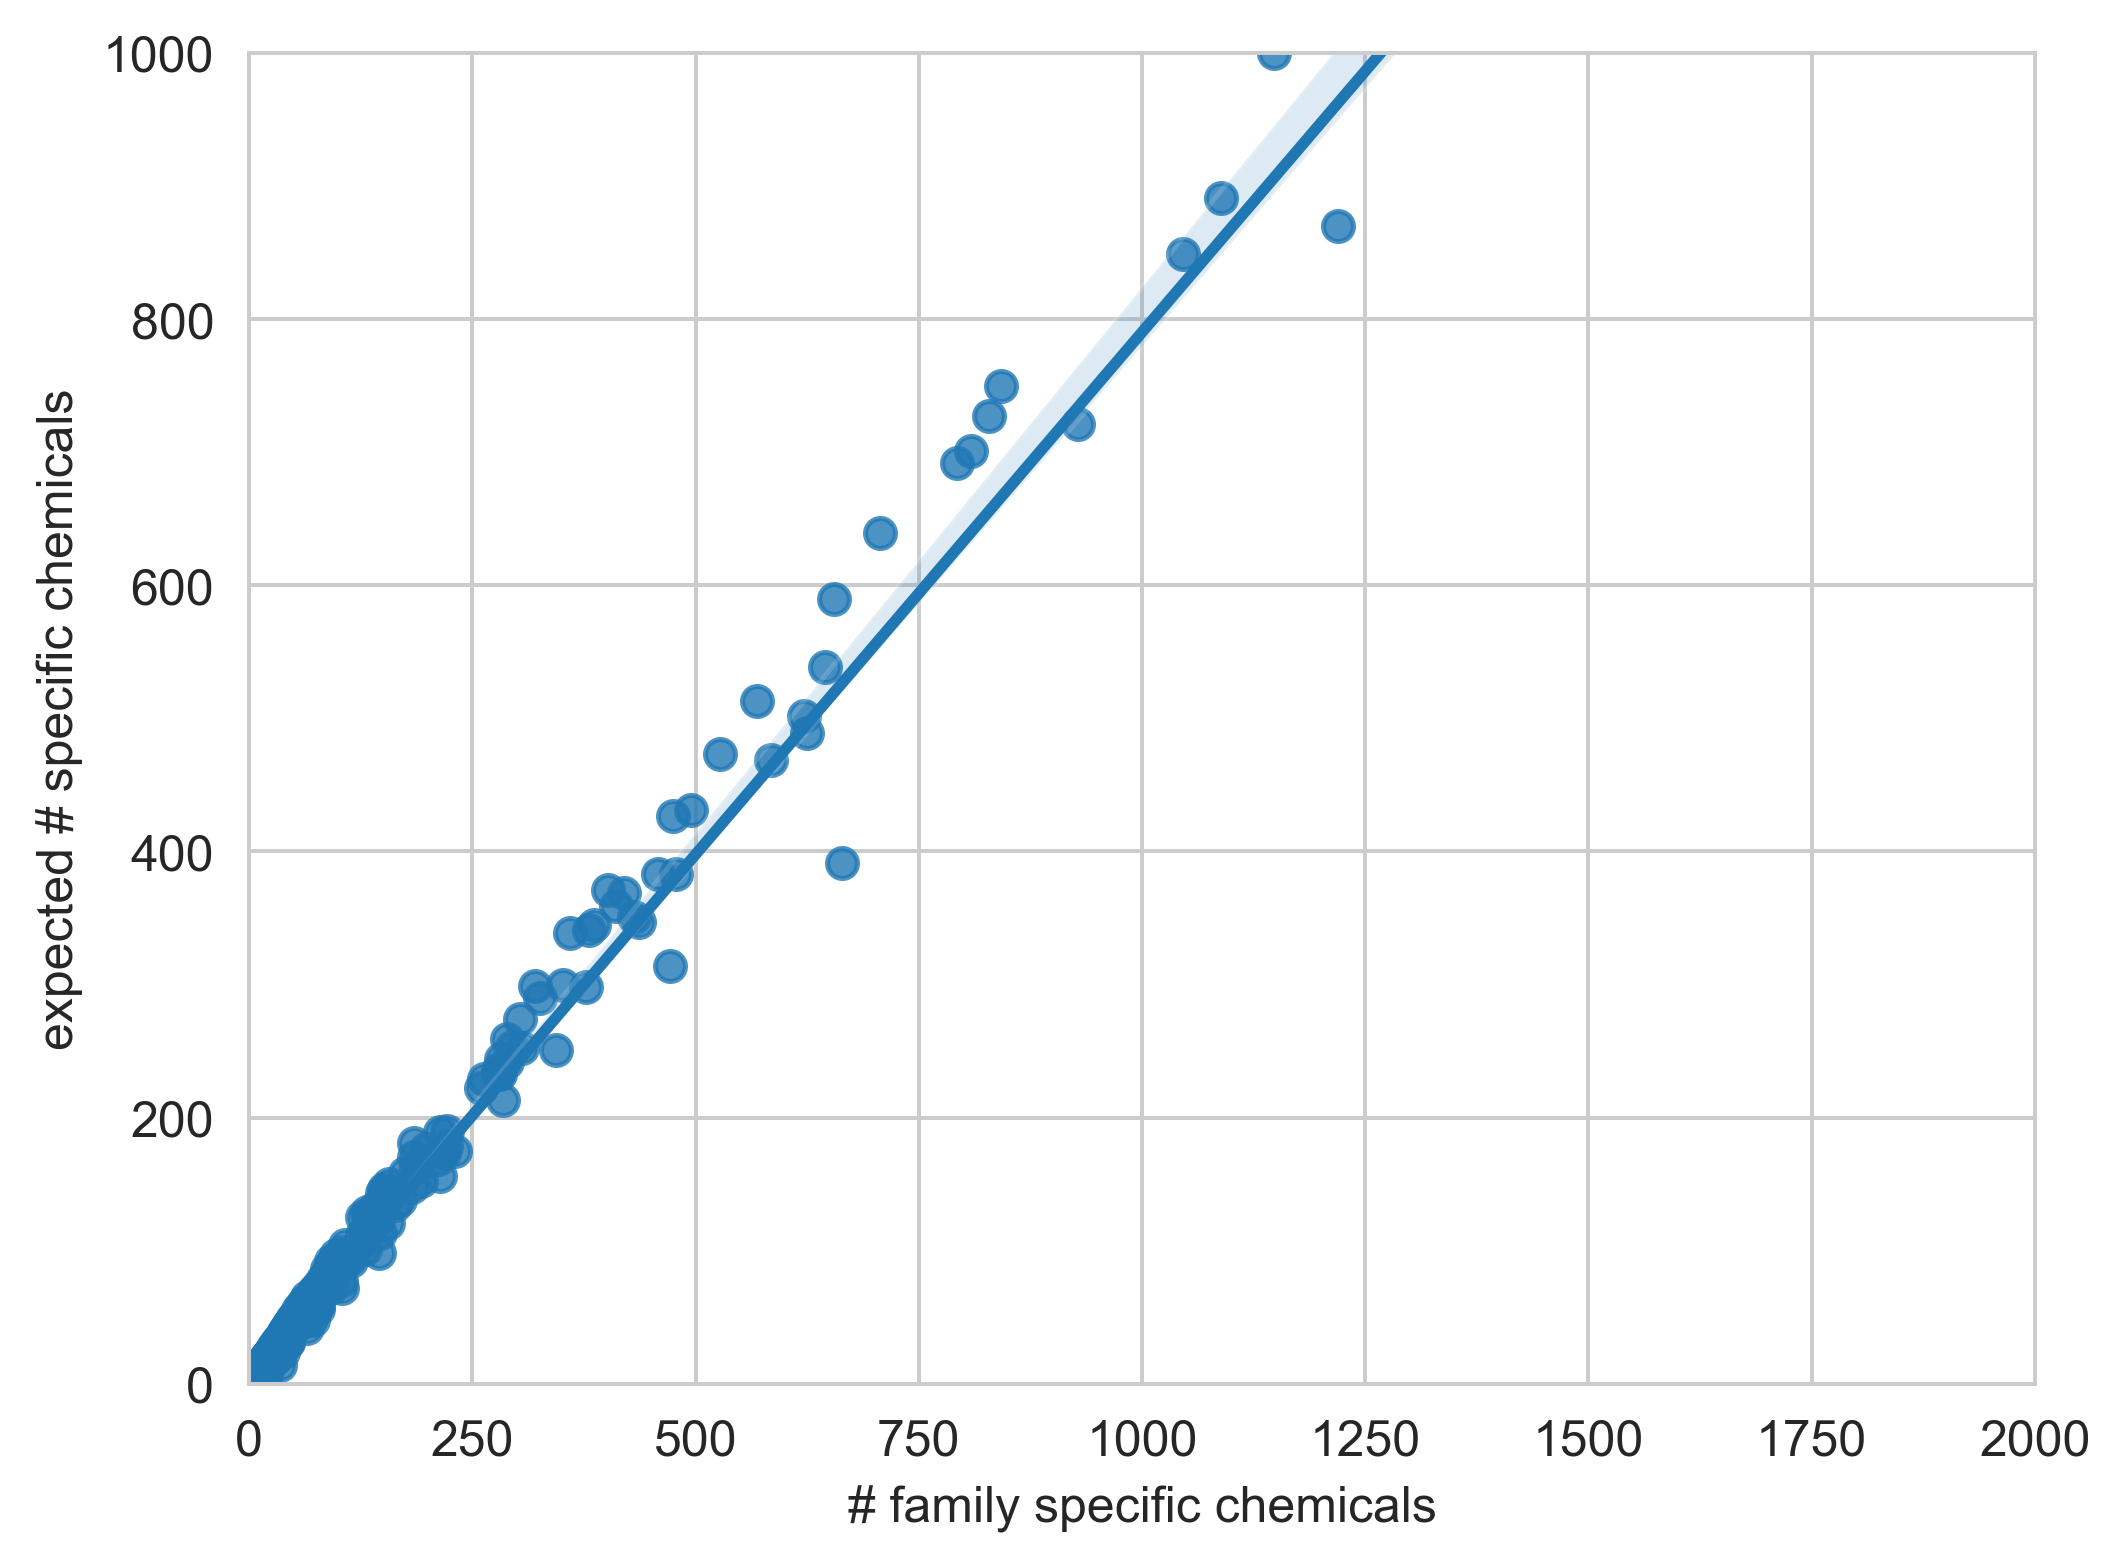

In [72]:
sns.regplot(family_df, x='# family specific chemicals', y='expected # specific chemicals')
plt.xlim(0, 2000)
plt.ylim(0, 1000)
plt.show()

<AxesSubplot: xlabel='observed # med plants', ylabel='expected # med plants'>

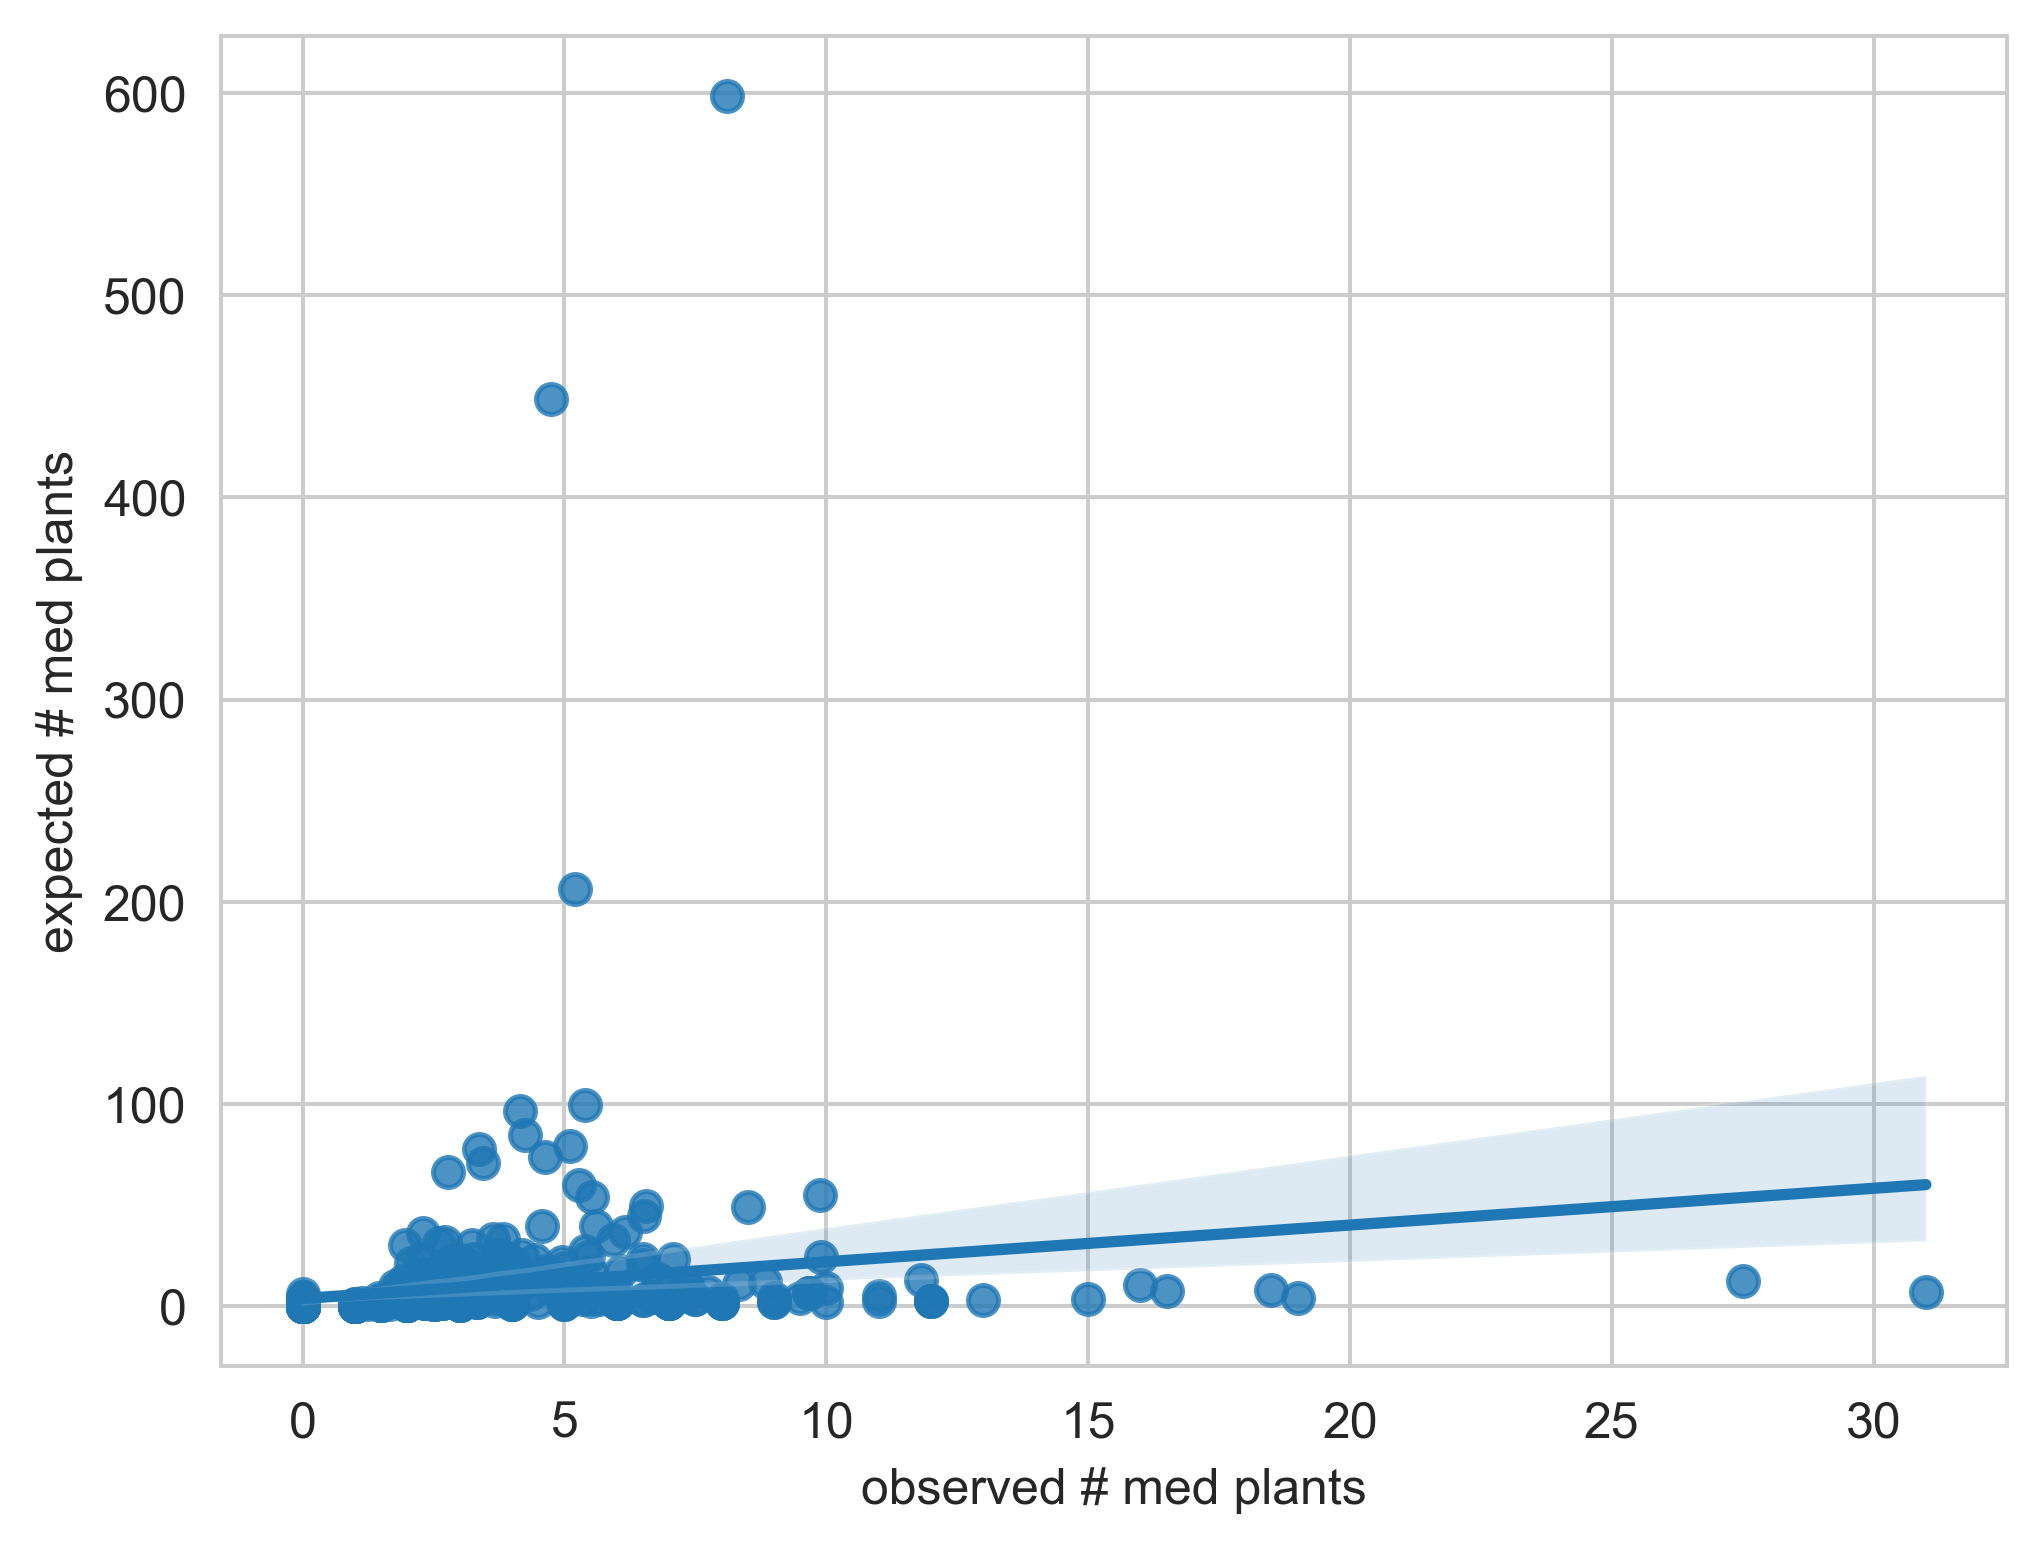

In [71]:
sns.regplot(family_df, x='observed # med plants', y='expected # med plants')

(0.0, 1000.0)

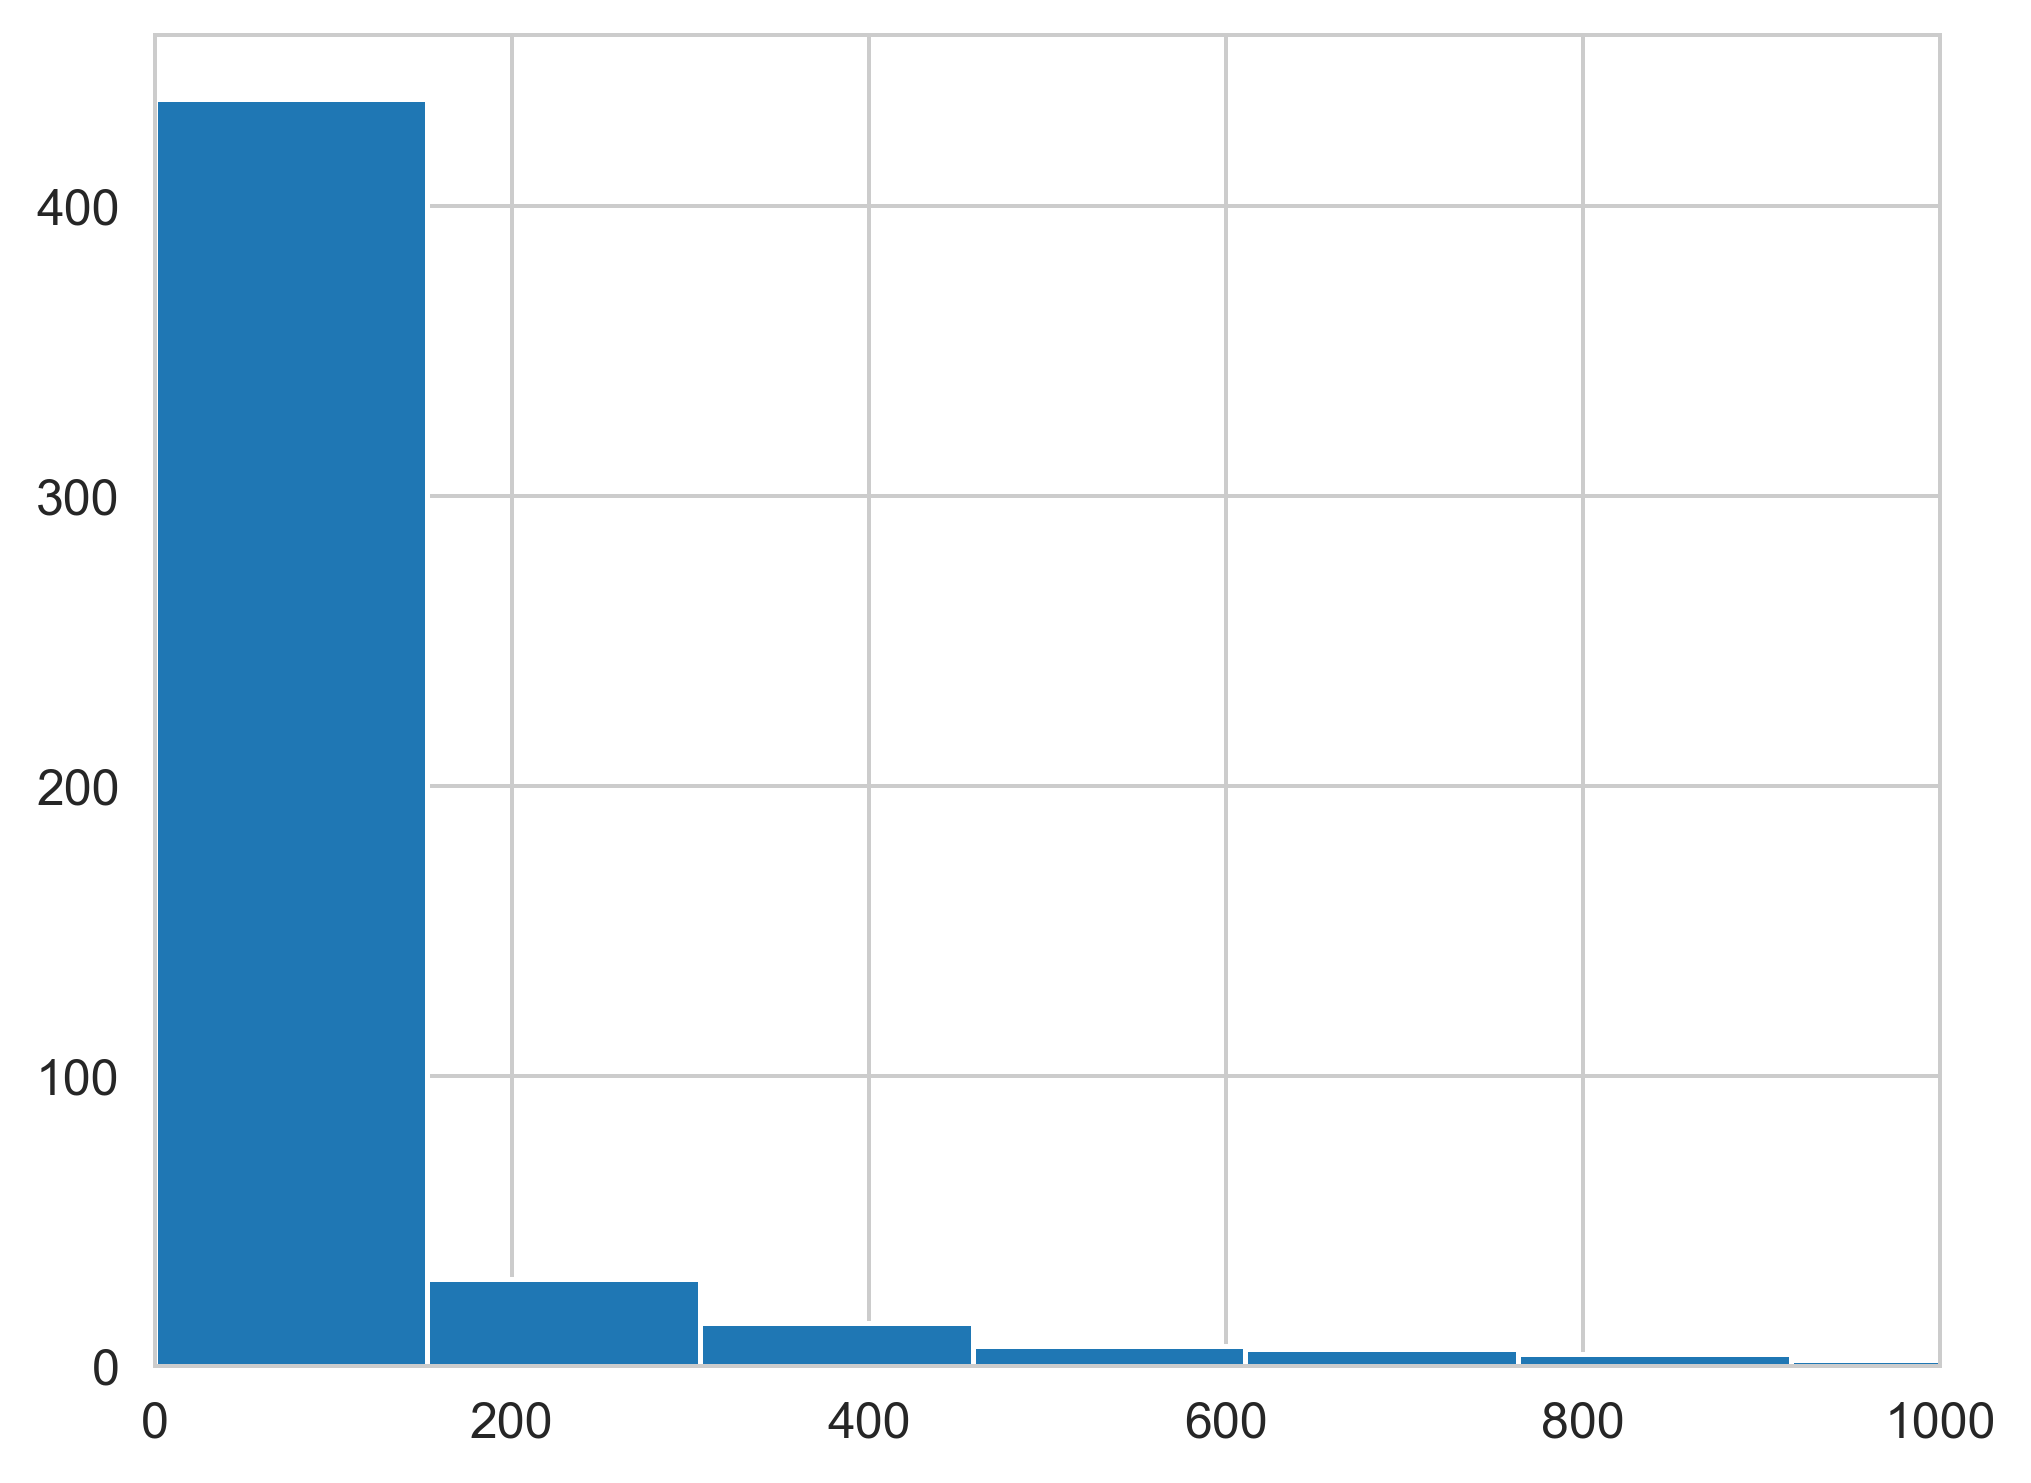

In [22]:
family_df['# family specific chemicals'].hist(bins=50)
plt.xlim(0, 1000)

In [24]:
norm_family_df.sort_values(by=['# family specific chemicals'], inplace=True, ascending=False)

In [25]:
norm_family_df.sort_values(by=['# chemicals'], inplace=True, ascending=False)

In [26]:
norm_family_df.head(10)

,# chemicals,# family specific chemicals,# med plants,# plants in fam
fam_name,,,,
Asteraceae,1.000000,1.000000,0.779859,1.000000
Fabaceae,0.802125,0.770591,1.000000,0.749351
Lamiaceae,0.556971,0.470080,0.419204,0.344457
Rutaceae,0.374313,0.282834,0.194379,0.165740
Solanaceae,0.282471,0.194317,0.217799,0.118280
Apiaceae,0.280841,0.194710,0.245902,0.161290
Euphorbiaceae,0.270394,0.196019,0.243560,0.129774
Apocynaceae,0.264054,0.244075,0.210773,0.141268
Rubiaceae,0.260793,0.150321,0.163934,0.132369


In [27]:
med_only = norm_family_df[norm_family_df['# med plants'] > 0]
med_only.shape

(293, 4)

<AxesSubplot: ylabel='fam_name'>

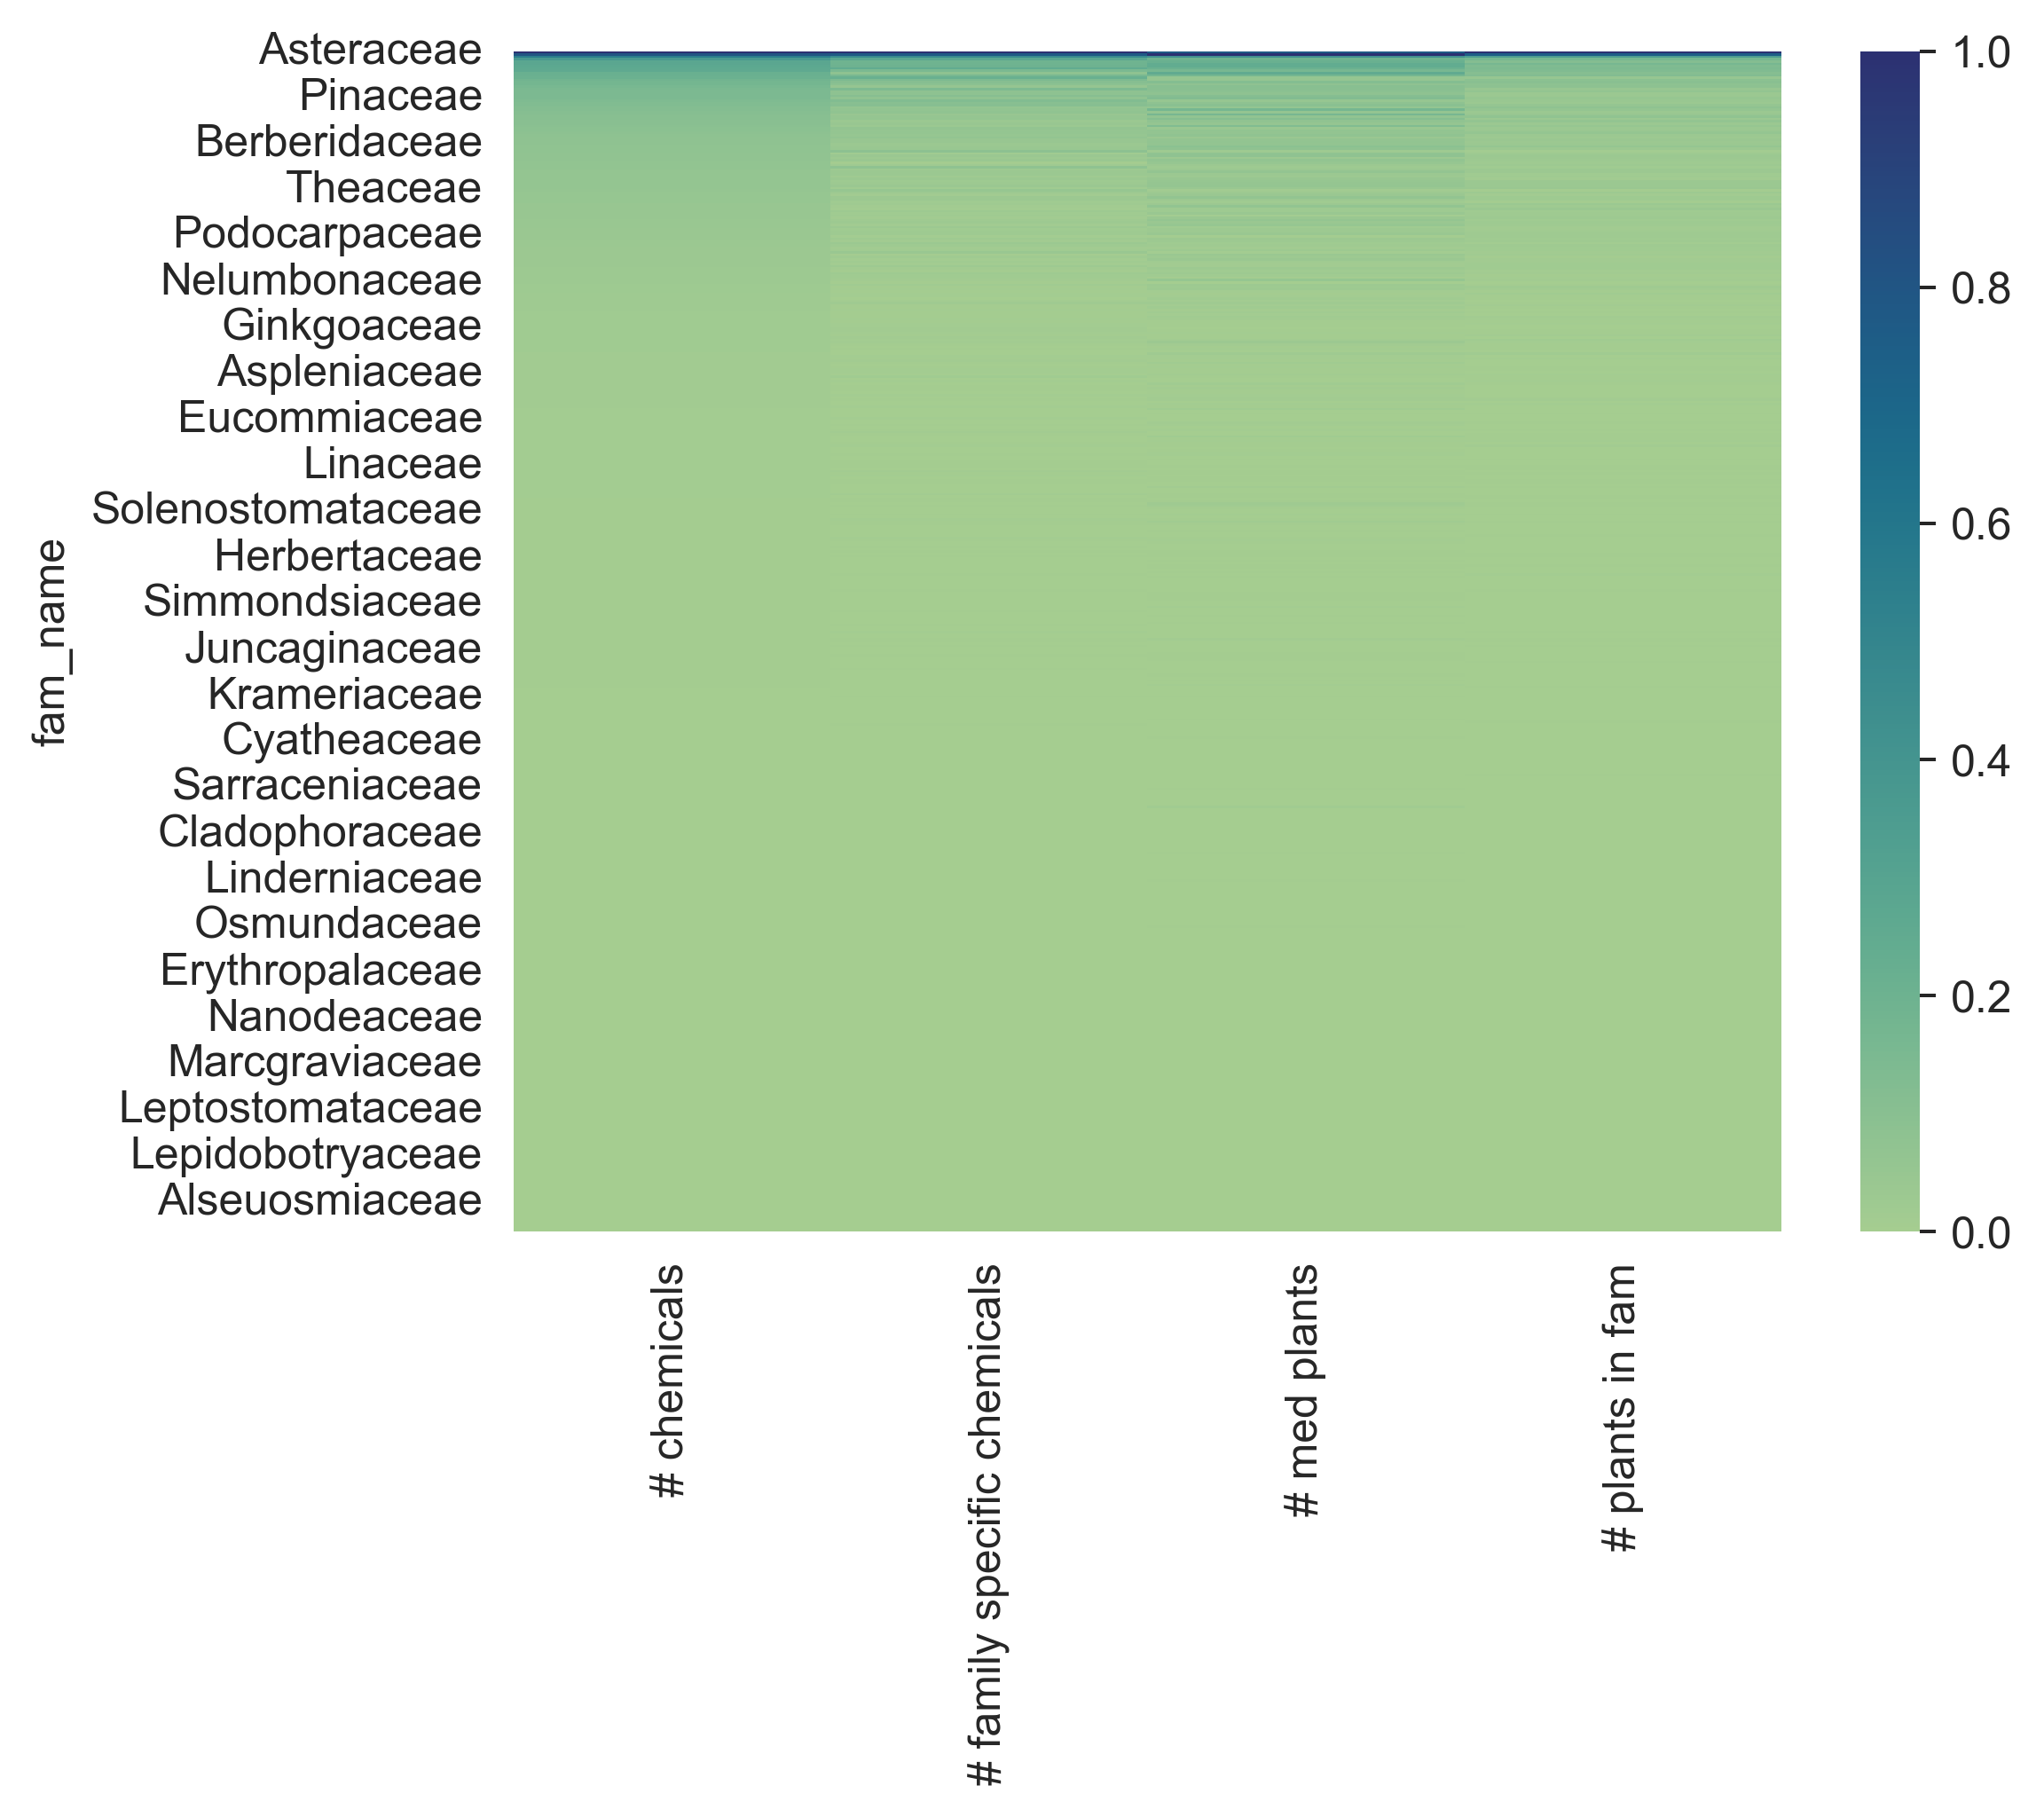

In [28]:
sns.heatmap(norm_family_df,cmap="crest")

In [33]:
family_df.sort_values(by='# med plants', ascending=False)[:10]

,# chemicals,# family specific chemicals,# med plants,# plants in fam
fam_name,,,,
Fabaceae,13285,5885,427,2022
Asteraceae,16562,7637,333,2698
Lamiaceae,9225,3590,179,930
Rosaceae,3568,655,108,300
Apiaceae,4652,1487,105,436
Euphorbiaceae,4479,1497,104,351
Solanaceae,4679,1484,93,320
Apocynaceae,4374,1864,90,382
Rutaceae,6200,2160,83,448


<AxesSubplot: ylabel='fam_name'>

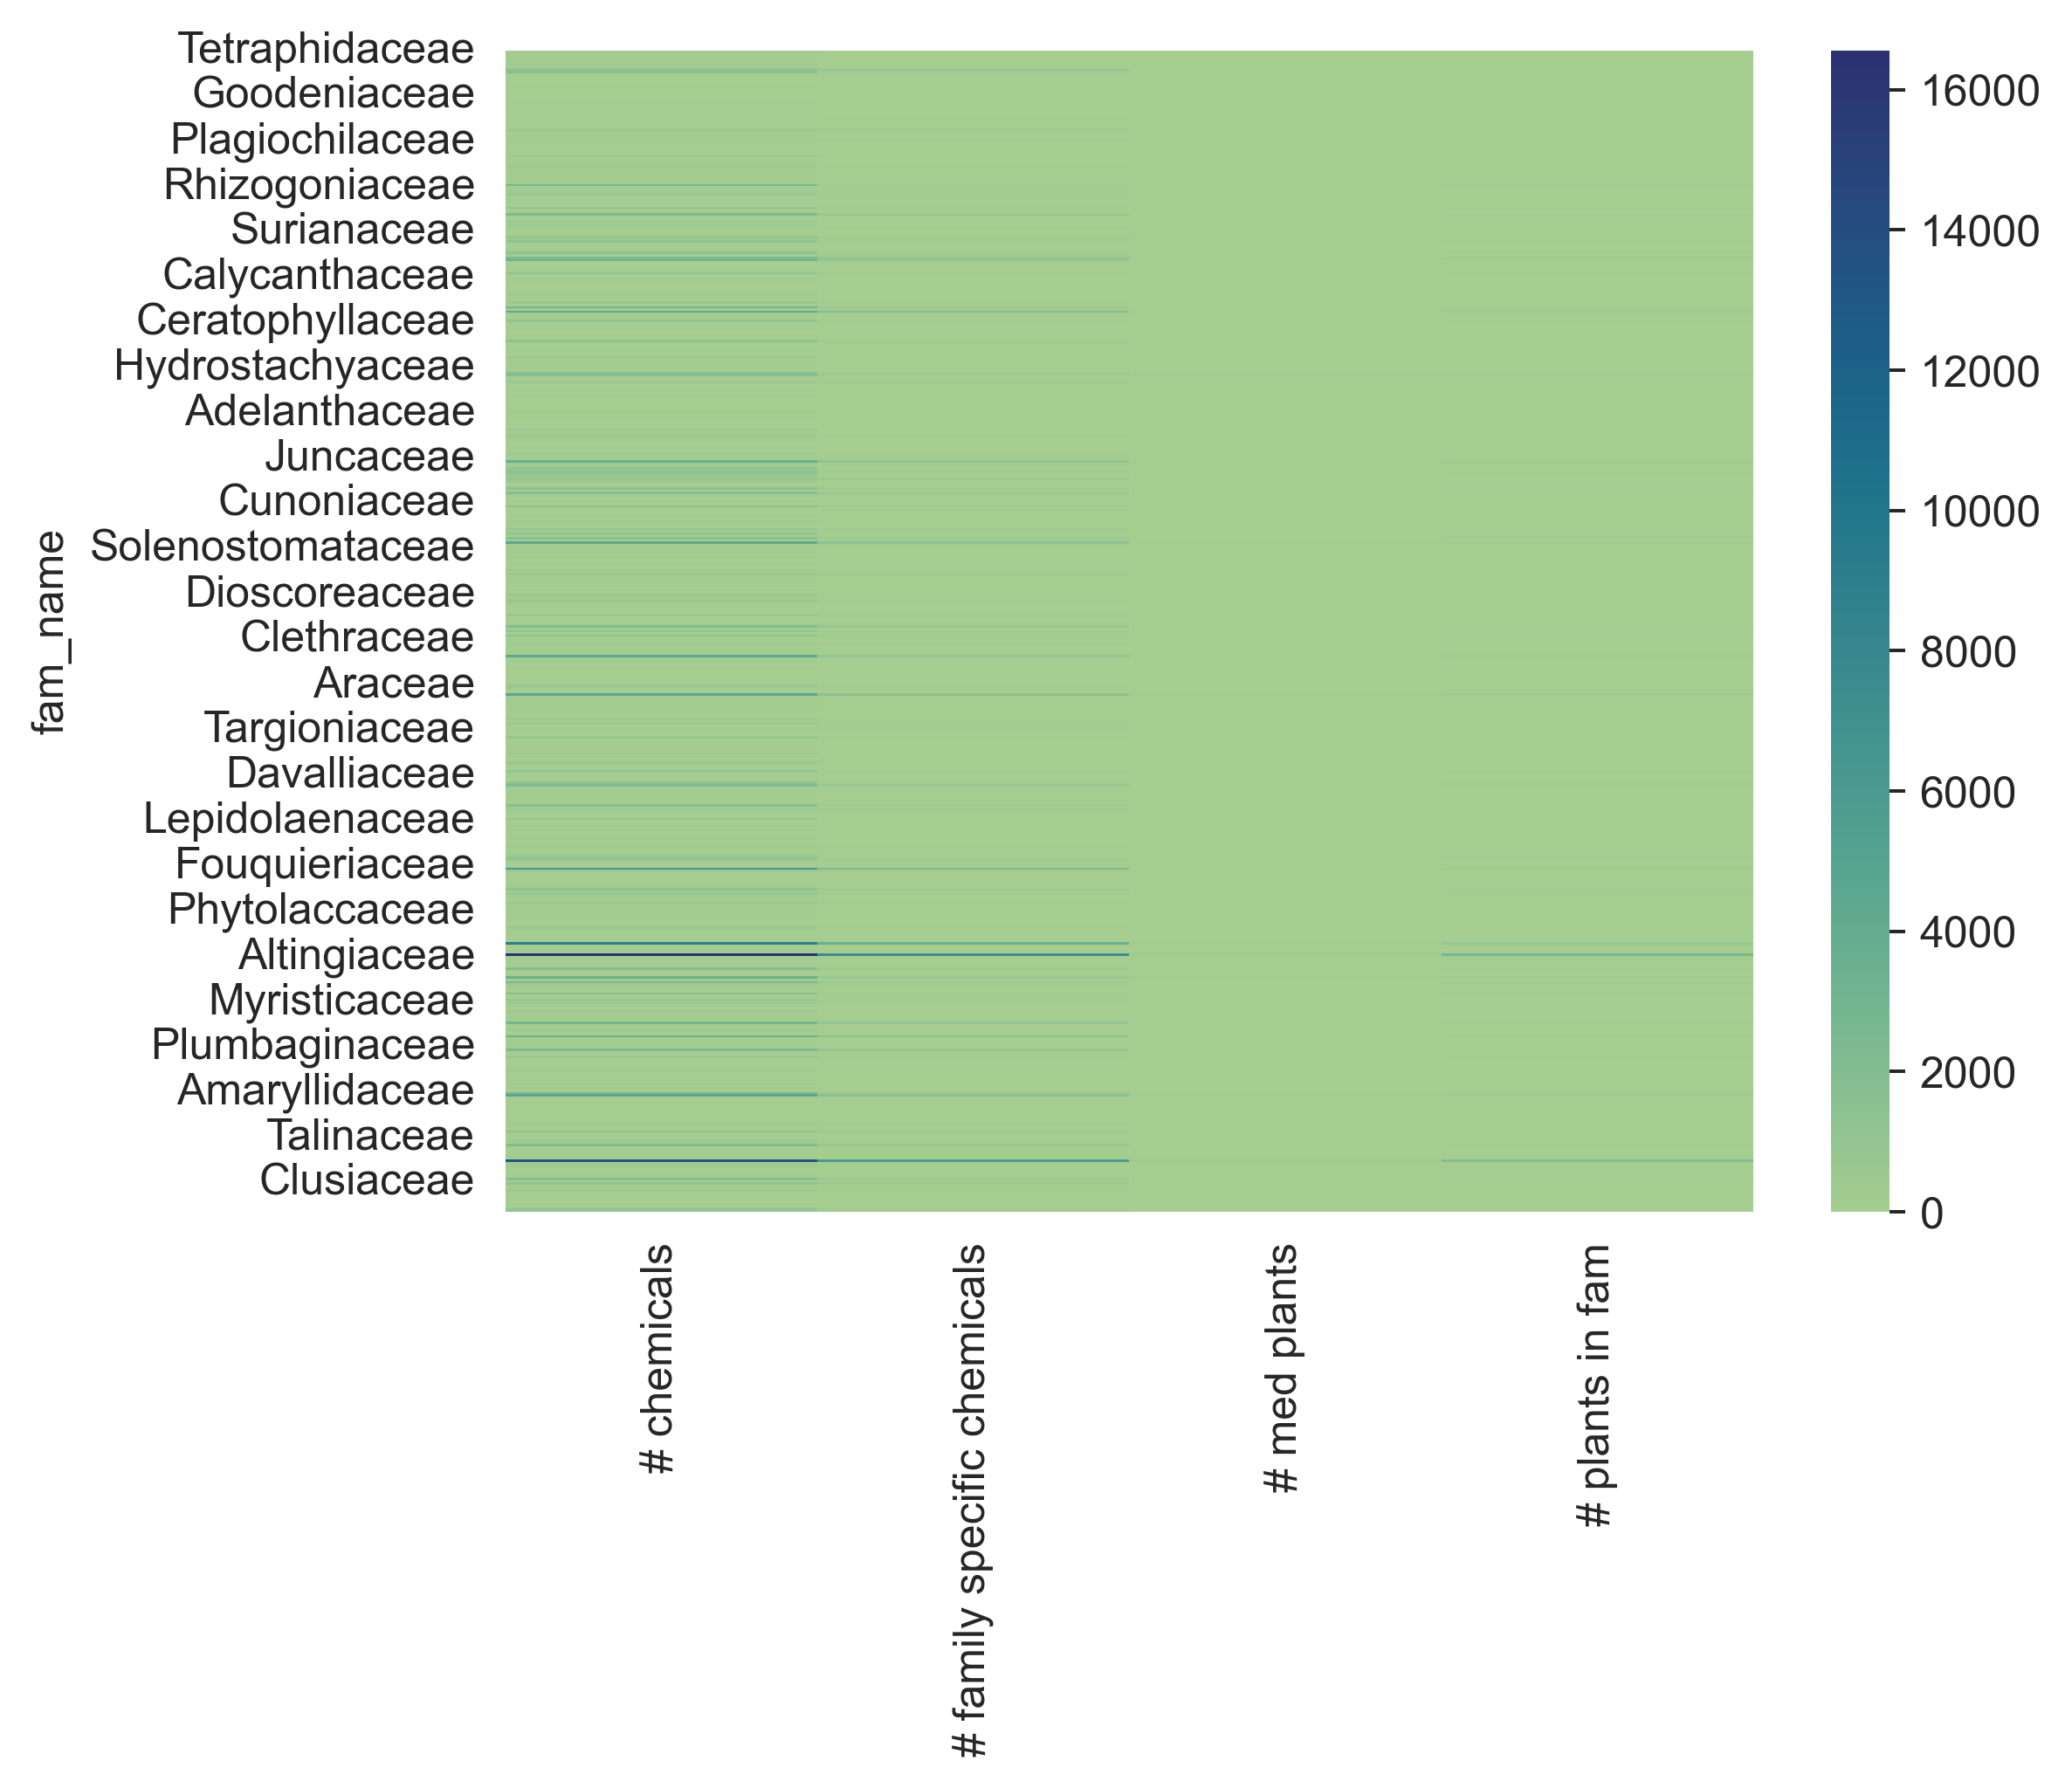

In [35]:
sns.heatmap(family_df,cmap="crest")